In [82]:
#Importing the required libraries

import sqlite3
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches


***********************************************************************************************
We will first read the data set provided to gain insight on the infomation give to us
***********************************************************************************************

In [83]:
db_path = "/Users/luyufish/Downloads/data/agri.db"

conn = sqlite3.connect(db_path)

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:", tables)

if tables:
    table_name = tables[0][0]  
    # Fetch all rows from the table
    df = pd.read_sql(f"SELECT * FROM {table_name};", conn)  
    
    print("\nFirst 5 entries from the table:", table_name)
    # Display only the first 5 rows
    print(tabulate(df.head(), headers='keys', tablefmt='pretty', showindex=False))  
    
conn.close()

Tables in database: [('farm_data',)]

First 5 entries from the table: farm_data
+----------------------+---------------------------+---------------------+-------------+-------------------------+---------------------+------------------------------+------------------+------------------+-----------------+-------------------------+-------------------------+-------------------------+-----------+-------------------------+
| System Location Code | Previous Cycle Plant Type |     Plant Type      | Plant Stage | Temperature Sensor (°C) | Humidity Sensor (%) | Light Intensity Sensor (lux) | CO2 Sensor (ppm) | EC Sensor (dS/m) | O2 Sensor (ppm) | Nutrient N Sensor (ppm) | Nutrient P Sensor (ppm) | Nutrient K Sensor (ppm) | pH Sensor | Water Level Sensor (mm) |
+----------------------+---------------------------+---------------------+-------------+-------------------------+---------------------+------------------------------+------------------+------------------+-----------------+-----------------

In [84]:
print("\nInformation about the data:")
df.info()  


Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       5

***********************************************************************************************
Taking a look at infomation about the data , we can see that Nutrient Sensors should be numerical and therefore we have to convert the Nutrient to numerical as it is an object data type, we also convert everything to float to ensure consistency 
***********************************************************************************************

In [85]:
# Columns that should be numeric (including nutrient sensors)
numeric_cols = [
    "Temperature Sensor (°C)", 
    "Light Intensity Sensor (lux)", 
    "CO2 Sensor (ppm)", 
    "EC Sensor (dS/m)", 
    "O2 Sensor (ppm)", 
    "pH Sensor", 
    "Water Level Sensor (mm)",
    "Nutrient N Sensor (ppm)", 
    "Nutrient P Sensor (ppm)", 
    "Nutrient K Sensor (ppm)"
]

# Convert all relevant columns to float, while handling any errors (such as non-numeric values)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# If needed, convert all columns to float after coercion to handle any 'NaN' values properly
df[numeric_cols] = df[numeric_cols].astype(float)

# Checking the data types after conversion to ensure the columns are now numeric
print(df.dtypes)

System Location Code             object
Previous Cycle Plant Type        object
Plant Type                       object
Plant Stage                      object
Temperature Sensor (°C)         float64
Humidity Sensor (%)             float64
Light Intensity Sensor (lux)    float64
CO2 Sensor (ppm)                float64
EC Sensor (dS/m)                float64
O2 Sensor (ppm)                 float64
Nutrient N Sensor (ppm)         float64
Nutrient P Sensor (ppm)         float64
Nutrient K Sensor (ppm)         float64
pH Sensor                       float64
Water Level Sensor (mm)         float64
dtype: object


***********************************************************************************************
Since plant stage is our main target we check if there is any missing values and remove if there is any missing plant stages 
***********************************************************************************************

In [86]:
missing_target_values = df['Plant Stage'].isnull().sum()

if missing_target_values > 0:
    df = df.dropna(subset=['Plant Stage'])

print(f"Missing values in 'Plant Stage' after handling: {df['Plant Stage'].isnull().sum()}")

Missing values in 'Plant Stage' after handling: 0


***********************************************************************************************
Taking a look at the data, we will remove irrelevant columns such as the location code, previous cycle plant type. Humidity Sensors will also be removed due to significant number of missing values, which could make it less reliable for analysis.

We then Clean the data further to ensure consistency, remove errors, handle missing values, and standardize formats.
1. Standardize Text Columns (Plant Type, Plant Stage)
2. Fix units for sensor columns
3. Handle Missing Values
4. Mapping for categorical columns
5. Detect & Handle Outliers as well as duplicate 
***********************************************************************************************

***********************************************************************************************
Step 1. Standardize Text Columns 

*******************************************************************************************

In [87]:
# 1. Standardizing the text columns
df_cleaned = df.copy()

text_columns = df_cleaned.select_dtypes(include=['object']).columns

for col in text_columns:
    df_cleaned[col] = df_cleaned[col].str.lower().str.strip()

***********************************************************************************************
Step 2 : Fix units for sensor columns

 In this step, negative values in specific sensor columns (CO2, EC, nutrients, O2, and water level) are replaced with zero to ensure that all readings are non-negative. Missing values (None or NaN) are left unchanged. This helps maintain data consistency and ensures that the sensor data is logically valid for analysis.
***********************************************************************************************

In [88]:
# 2. Fix units for sensor columns

# Ensure CO2 values are non-negative (ppm)
df_cleaned['CO2 Sensor (ppm)'] = df_cleaned['CO2 Sensor (ppm)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative CO2 values
)

# Ensure EC values are non-negative and in expected range (dS/m)
df_cleaned['EC Sensor (dS/m)'] = df_cleaned['EC Sensor (dS/m)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative EC values
)

# Ensure Nutrient N values are non-negative (ppm)
df_cleaned['Nutrient N Sensor (ppm)'] = df_cleaned['Nutrient N Sensor (ppm)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative nutrient N values
)

# Ensure Nutrient P values are non-negative (ppm)
df_cleaned['Nutrient P Sensor (ppm)'] = df_cleaned['Nutrient P Sensor (ppm)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative nutrient P values
)

# Ensure Nutrient K values are non-negative (ppm)
df_cleaned['Nutrient K Sensor (ppm)'] = df_cleaned['Nutrient K Sensor (ppm)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative nutrient K values
)

# Ensure O2 values are non-negative (ppm)
df_cleaned['O2 Sensor (ppm)'] = df_cleaned['O2 Sensor (ppm)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative O2 values
)

# Ensure Water Level values are non-negative (mm)
df_cleaned['Water Level Sensor (mm)'] = df_cleaned['Water Level Sensor (mm)'].apply(
    lambda x: max(0, x) if x is not None else None  # Ensure no negative water level values
)


***********************************************************************************************
Step 3: Handle Missing Values

 I handled missing values by replacing empty strings with NaN. For numerical columns, I filled missing values with the median, and for text columns, I replaced them with 'unknown'. This ensures no missing data remains.
***********************************************************************************************

In [89]:
# 3. Handling missing values

# Replace empty strings with NaN
df_cleaned.replace("", np.nan, inplace=True)

# Identify numerical columns (only float64 since we already did it above) and text columns
numerical_columns = df_cleaned.select_dtypes(include=['float64']).columns
text_columns = df_cleaned.select_dtypes(include=['object']).columns

# For numerical columns (float64), replace NaN with the column median
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].median())

# For text columns, replace NaN with 'unknown'
df_cleaned[text_columns] = df_cleaned[text_columns].fillna('unknown')



***********************************************************************************************
Step 4. Mapping for categorical columns

I mapped categorical columns to numerical values using predefined mappings. For example, plant types and stages were assigned numbers, with missing or unmatched values filled as -1. This ensures that all categorical data is converted to numerical format for analysis, while numerical columns remain in decimal format.
***********************************************************************************************

In [90]:
# 4. Mapping for categorical columns
# Separate numerical and categorical columns
numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# Define mapping for each categorical column (example, modify according to your data)
# For plant stage, mapping from stages to numbers 1-4
mapping_dict = {
    'Previous Cycle Plant Type': {'herbs': 1, 'leafy greens': 2, 'vine crops': 3, 'fruiting vegetables': 4},
    'Plant Type': {'fruiting vegetables': 1, 'herbs': 2, 'leafy greens': 3, 'vine crops': 4},
    'Plant Stage': {'seedling': 1, 'vegetative': 2, 'maturity': 3}
}

for col in categorical_columns:
    if col in mapping_dict:
        df_cleaned[col] = df_cleaned[col].map(mapping_dict[col]).fillna(-1)  # -1 if there's a value that doesn't match the mapping

df_cleaned[numerical_columns] = df_cleaned[numerical_columns].apply(pd.to_numeric, errors='coerce')

df_cleaned.head()


,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,zone_d,1,4,3,23.34,68.70,454.0,937.0,1.82,4.0,161.0,64.0,201.0,6.1,28.150346
1,zone_g,1,4,2,-24.16,63.14,441.0,938.0,2.13,6.0,161.0,53.0,0.0,6.5,31.000000
2,zone_f,1,2,3,23.84,68.70,562.0,1246.0,1.21,8.0,228.0,79.0,292.0,6.4,26.000000
3,zone_g,1,1,2,22.61,68.70,651.0,1346.0,1.96,6.0,0.0,0.0,289.0,6.6,0.000000
4,zone_b,3,3,1,22.88,68.70,144.0,812.0,2.76,5.0,61.0,19.0,168.0,5.5,28.000000


***********************************************************************************************
Step 5. Detect & Handle Outliers as well as duplicate 

I cleaned the dataset by first removing duplicate rows using drop_duplicates() to ensure data uniqueness. Then, you applied the IQR (Interquartile Range) method to identify and remove outliers from the numerical columns. This was done by calculating the IQR, defining upper and lower bounds, and filtering out row
***********************************************************************************************

In [91]:
# Step 5. Detect & Handle Outliers as well as duplicate 
# 1. Removing duplicates
df_cleaned = df_cleaned.drop_duplicates()

# 2. Removing outliers using IQR method

# Calculate the IQR for each numerical column
Q1 = df_cleaned[numerical_columns].quantile(0.25)
Q3 = df_cleaned[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where any numerical column has outlier values
df_cleaned = df_cleaned[~((df_cleaned[numerical_columns] < lower_bound) | (df_cleaned[numerical_columns] > upper_bound)).any(axis=1)]

df_cleaned.head()



,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
2,zone_f,1,2,3,23.84,68.7,562.0,1246.0,1.21,8.0,228.0,79.0,292.0,6.4,26.000000
5,zone_c,3,1,3,25.96,68.7,675.0,1338.0,1.75,8.0,227.0,53.0,258.0,6.2,23.092135
6,zone_a,2,4,3,23.21,68.7,514.0,1103.0,1.14,8.0,174.0,62.0,217.0,5.5,35.000000
9,zone_b,3,4,3,25.59,68.7,435.0,845.0,2.07,8.0,150.0,70.0,210.0,5.3,27.835062
10,zone_g,2,2,3,23.15,68.7,444.0,1090.0,1.77,7.0,0.0,52.0,347.0,6.4,35.000000


***********************************************************************************************
Now that we have done with data cleaning we will proceed with data visualisation.
***********************************************************************************************

***********************************************************************************************
1. Plant Stages and Temperature Sensor 

Temperature plays a crucial role in plant growth, influencing metabolic rates, photosynthesis, and developmental transitions across stages, making a boxplot ideal for visualizing its distribution, median, variability, and potential outliers across Seedling, Vegetative, and Maturity stages.


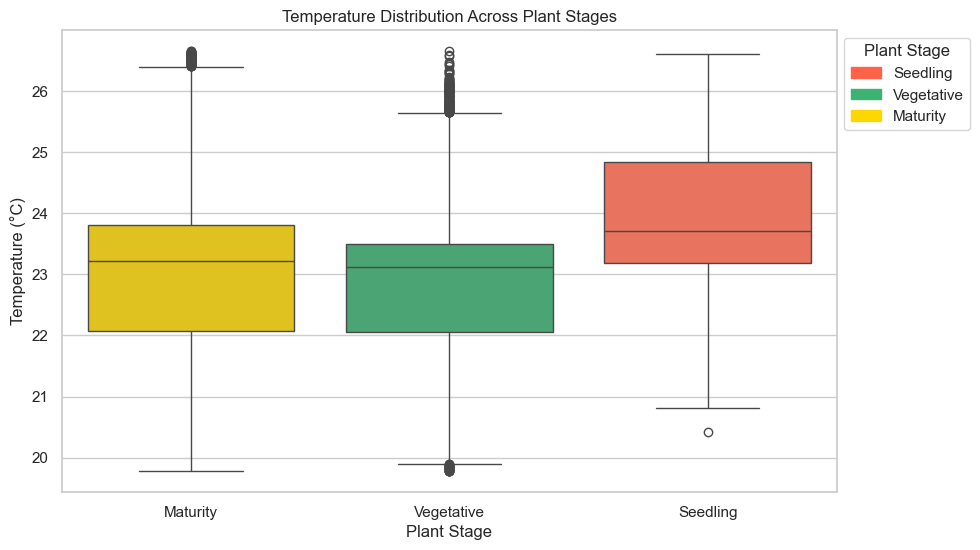

                   count       mean       std    min    25%    50%    75%  \
Plant Stage Name                                                            
Maturity          6372.0  23.049083  1.477692  19.79  22.07  23.21  23.80   
Seedling          8093.0  23.889759  1.154415  20.42  23.18  23.71  24.84   
Vegetative        7915.0  22.833112  1.269083  19.78  22.05  23.12  23.49   

                    max  
Plant Stage Name         
Maturity          26.65  
Seedling          26.61  
Vegetative        26.65  


In [92]:
palette = {'Seedling': '#FF6347', 'Vegetative': '#3CB371', 'Maturity': '#FFD700'}

stage_mapping = {1: 'Seedling', 2: 'Vegetative', 3: 'Maturity'}
df_cleaned['Plant Stage Name'] = df_cleaned['Plant Stage'].map(stage_mapping)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Plant Stage Name', y='Temperature Sensor (°C)', data=df_cleaned, hue='Plant Stage Name', palette=palette, legend=False)

plt.title('Temperature Distribution Across Plant Stages')
plt.xlabel('Plant Stage')
plt.ylabel('Temperature (°C)')

# Custom legend for plant stages
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
plt.legend(handles=legend_patches, title='Plant Stage', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

stats = df_cleaned.groupby('Plant Stage Name')['Temperature Sensor (°C)'].describe()
print(stats)

Seedlings experience the highest and most stable temperatures, with an average of 23.89°C and the lowest variability (std = 1.15°C), meaning their environment is more controlled. In contrast, mature plants have a slightly lower average temperature (23.05°C) but the highest variability (std = 1.48°C), indicating more temperature fluctuations. The vegetative stage is the coolest, with the lowest average temperature (22.83°C) and moderate variability (std = 1.27°C), suggesting that this phase thrives in slightly cooler conditions, possibly to support leaf and structural growth.

I opted for a histogram with a KDE overlay instead of just a histogram because of the presence of outliers in the temperature data. While histograms show the frequency of values, they can be skewed by extreme values, making it harder to interpret the overall distribution. The KDE smooths the data and helps reveal the underlying trend or shape of the distribution, providing a clearer view of temperature variations across plant stages. This combination allows me to better understand the central tendency and spread of temperature, without the outliers dominating the visual representation.

Summary Statistics for Temperature Across Plant Stages:
                   count       mean       std    min    25%    50%    75%  \
Plant Stage Name                                                            
Maturity          6372.0  23.049083  1.477692  19.79  22.07  23.21  23.80   
Seedling          8093.0  23.889759  1.154415  20.42  23.18  23.71  24.84   
Vegetative        7915.0  22.833112  1.269083  19.78  22.05  23.12  23.49   

                    max  
Plant Stage Name         
Maturity          26.65  
Seedling          26.61  
Vegetative        26.65  


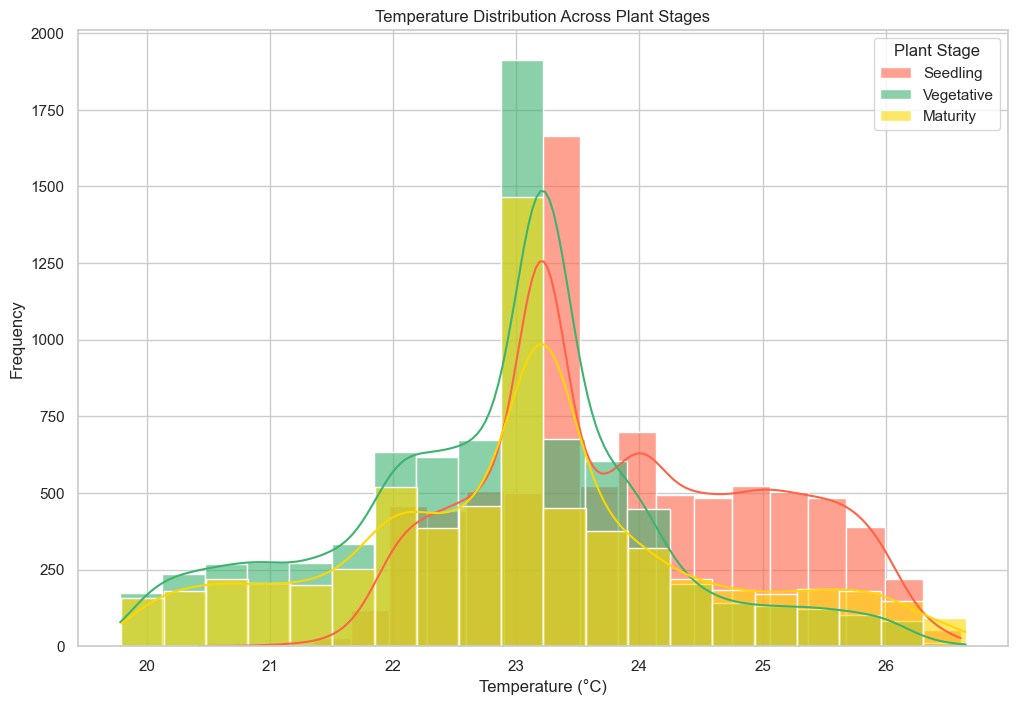

In [93]:
palette = {'Seedling': '#FF6347', 'Vegetative': '#3CB371', 'Maturity': '#FFD700'}
stage_mapping = {1: 'Seedling', 2: 'Vegetative', 3: 'Maturity'}
df_cleaned['Plant Stage Name'] = df_cleaned['Plant Stage'].map(stage_mapping)

summary_stats = df_cleaned.groupby('Plant Stage Name')['Temperature Sensor (°C)'].describe()
print("Summary Statistics for Temperature Across Plant Stages:")
print(summary_stats)

plt.figure(figsize=(12, 8))

for stage, color in palette.items():
    stage_data = df_cleaned[df_cleaned['Plant Stage Name'] == stage]
    sns.histplot(stage_data['Temperature Sensor (°C)'], kde=True, bins=20, color=color, label=stage, alpha=0.6)

plt.title('Temperature Distribution Across Plant Stages')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.legend(title='Plant Stage', loc='upper right')
plt.show()


Based on my observation, the Seedling stage has the highest average temperature at 23.89°C and the least variability, with a standard deviation of 1.15°C. The Maturity stage follows closely with an average of 23.05°C and a standard deviation of 1.48°C, while the Vegetative stage has the lowest average at 22.83°C and the highest variability (1.27°C). This difference could be due to the varying energy requirements and sensitivity to temperature at each plant stage. Seedlings may thrive at slightly higher and more stable temperatures, while mature plants and those in the vegetative stage may show more tolerance to a wider range of temperatures.

***********************************************************************************************

***********************************************************************************************
2. Plant Stages and Light Intensity 

Light intensity influences photosynthesis and growth, with seedlings often requiring lower intensity, while mature plants benefit from higher levels for optimal energy production. A bar plot is used to compare the average light intensity across plant stages, making it easy to observe overall trends and differences between categories.

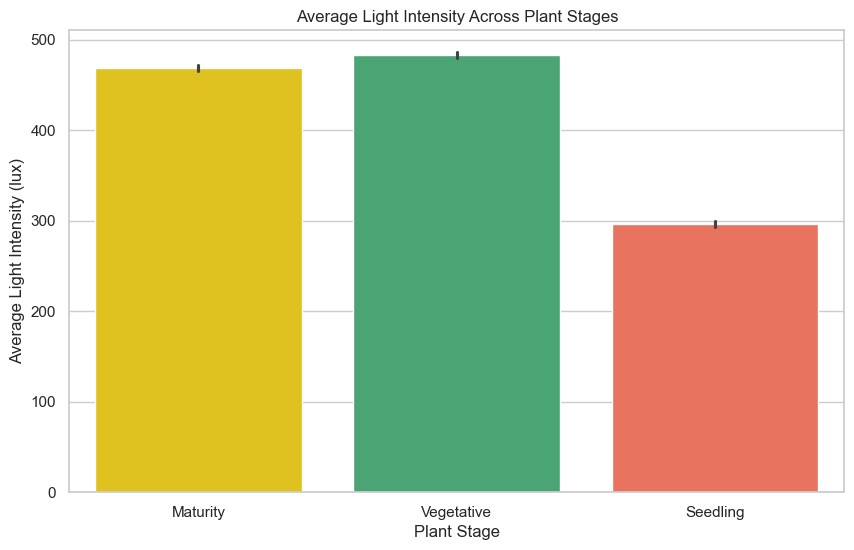

                   count        mean         std    min     25%    50%    75%  \
Plant Stage Name                                                                
Maturity          6372.0  469.224576  147.152084  199.0  367.75  446.0  572.0   
Seedling          8093.0  296.554677  136.690917 -144.0  200.00  259.0  403.0   
Vegetative        7915.0  482.953759  155.688291  199.0  372.00  459.0  600.0   

                    max  
Plant Stage Name         
Maturity          800.0  
Seedling          600.0  
Vegetative        800.0  


In [94]:
palette = {'Seedling': '#FF6347', 'Vegetative': '#3CB371', 'Maturity': '#FFD700'}

stage_mapping = {1: 'Seedling', 2: 'Vegetative', 3: 'Maturity'}
df_cleaned['Plant Stage Name'] = df_cleaned['Plant Stage'].map(stage_mapping)

plt.figure(figsize=(10, 6))
sns.barplot(x='Plant Stage Name', y='Light Intensity Sensor (lux)', data=df_cleaned, hue='Plant Stage Name', palette=palette, legend=False)

plt.title('Average Light Intensity Across Plant Stages')
plt.xlabel('Plant Stage')
plt.ylabel('Average Light Intensity (lux)')

plt.show()

summary_light = df_cleaned.groupby('Plant Stage Name')['Light Intensity Sensor (lux)'].describe()
print(summary_light)


Based on my analysis, light intensity increases as plants grow. Seedlings have the lowest average light intensity at 296.55 lux, with a range from 199 lux to 600 lux. Vegetative plants require slightly more light, with an average of 482.95 lux. Mature plants experience a similar light intensity, averaging 469.22 lux with a range from 199 lux to 800 lux, suggesting they thrive in more intense light but also face more variation. This indicates that as plants mature, they generally require higher and more stable light levels for optimal growth

***********************************************************************************************

***********************************************************************************************
3. Plant Stages and Nutrients N, P, K 

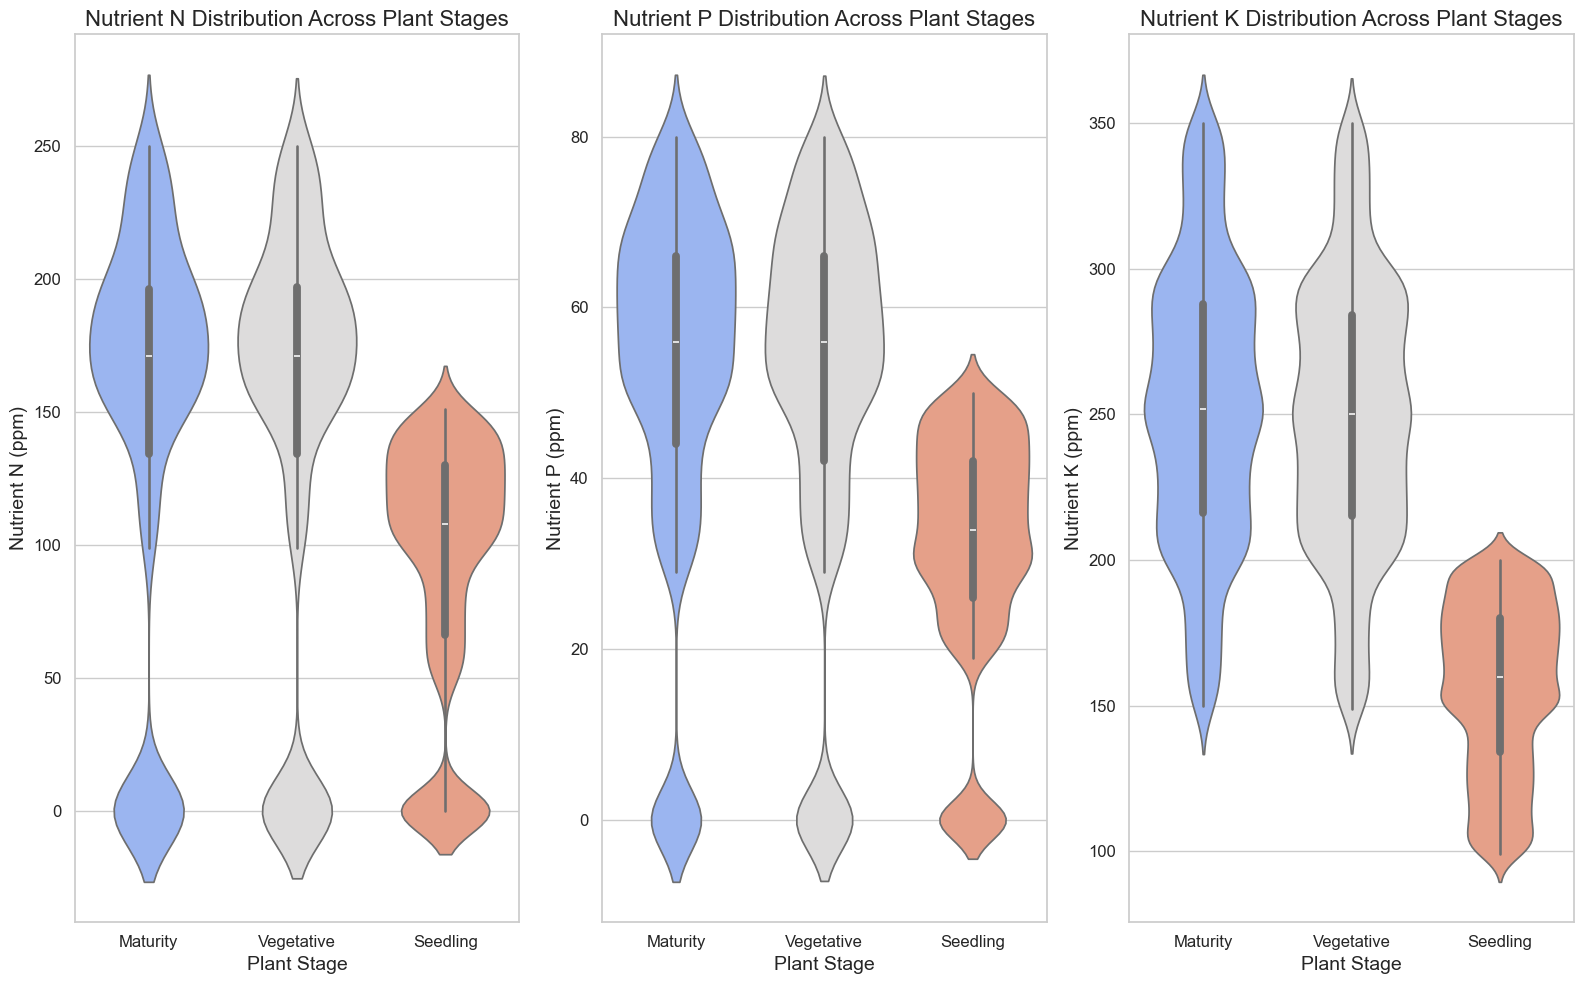

In [95]:

plt.figure(figsize=(16, 10))

# Violin plot for Nutrient N
plt.subplot(1, 3, 1)
sns.violinplot(x='Plant Stage Name', y='Nutrient N Sensor (ppm)', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)
plt.title('Nutrient N Distribution Across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('Nutrient N (ppm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Violin plot for Nutrient P
plt.subplot(1, 3, 2)
sns.violinplot(x='Plant Stage Name', y='Nutrient P Sensor (ppm)', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)
plt.title('Nutrient P Distribution Across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('Nutrient P (ppm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Violin plot for Nutrient K
plt.subplot(1, 3, 3)
sns.violinplot(x='Plant Stage Name', y='Nutrient K Sensor (ppm)', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)
plt.title('Nutrient K Distribution Across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('Nutrient K (ppm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()



Based on my observation, Nitrogen levels are highest in the Maturity and Vegetative stages, with median values around 150–200 ppm, while Seedlings show significantly lower concentrations, mostly below 100 ppm. Similarly, phosphorus levels peak in the Vegetative stage, with a median near 60 ppm, whereas Maturity maintains slightly lower levels, and Seedlings exhibit the lowest concentrations, often below 30 ppm. Potassium follows a similar trend to nitrogen, with Maturity and Vegetative stages showing higher median values around 250–300 ppm, whereas Seedlings have much lower levels, ranging from 100 to 200 ppm. The wide distribution in Maturity and Vegetative stages for nitrogen and potassium suggests variability in nutrient uptake, while phosphorus exhibits a more concentrated spread, especially in the Vegetative phase. Overall, the data indicates that Seedlings have the lowest nutrient concentrations, while Vegetative plants require the most phosphorus, and both Maturity and Vegetative stages exhibit high variability in nitrogen and potassium absorption.

***************************************************************************************

***************************************************************************************
4. Plant Stages and CO2 Sensor(ppm)

CO₂ levels influence plant growth by affecting photosynthesis, where higher concentrations can enhance growth up to an optimal point. A boxplot is used here to visualize the distribution of CO₂ levels across different plant stages, highlighting variations, medians, and potential outliers that may indicate stage-specific differences in CO₂ uptake and utilization.


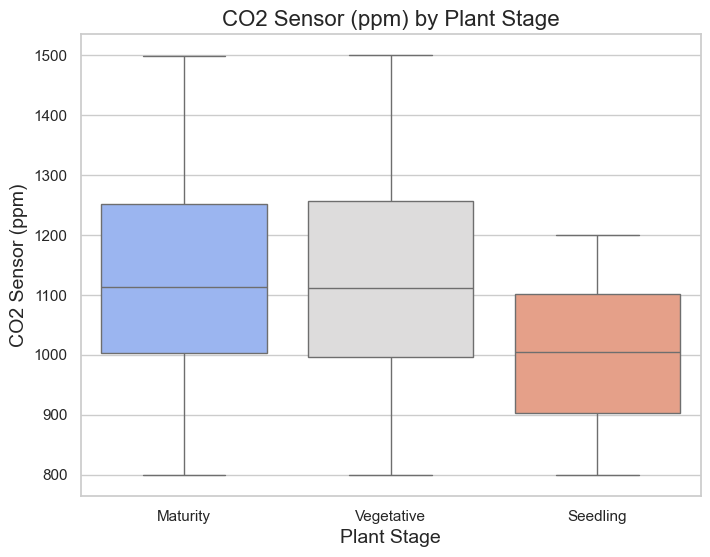

Summary statistics for CO2 Sensor (ppm):
                   count         mean         std    min     25%     50%  \
Plant Stage Name                                                           
Maturity          6372.0  1126.774482  179.203754  800.0  1003.0  1114.0   
Seedling          8093.0  1002.443717  115.084156  799.0   903.0  1004.0   
Vegetative        7915.0  1125.676058  182.706727  799.0   997.0  1111.0   

                     75%     max  
Plant Stage Name                  
Maturity          1251.0  1499.0  
Seedling          1102.0  1200.0  
Vegetative        1257.0  1500.0  


In [96]:
plt.figure(figsize=(8, 6))

sns.boxplot(x='Plant Stage Name', y='CO2 Sensor (ppm)', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)

plt.title('CO2 Sensor (ppm) by Plant Stage', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('CO2 Sensor (ppm)', fontsize=14)

plt.show()

summary = df_cleaned.groupby('Plant Stage Name')['CO2 Sensor (ppm)'].describe()
print("Summary statistics for CO2 Sensor (ppm):")
print(summary)

Based on my observation, CO₂ levels tend to increase as plants mature, which may be linked to their growing metabolic and photosynthetic demands. Seedlings have the lowest average CO₂ concentration at 1002.44 ppm, with a relatively stable range from 799 to 1200 ppm, indicating they thrive in lower CO₂ environments. As plants enter the vegetative and maturity stages, their CO₂ levels rise, averaging around 1125–1126 ppm, with a broader range extending up to 1500 ppm. This increase suggests that as plants grow, they either absorb more CO₂ for photosynthesis or are exposed to higher CO₂ concentrations to support their energy needs and structural development. 
***********************************************************************************************

***********************************************************************************************
5. Plant Stages and Electrical Conductivity (EC) Sensor (dS/m)

EC reflects nutrient availability, which influences plant growth at different stages. A bar plot is used here because it effectively displays the average EC levels for each plant stage, allowing for clear comparisons of nutrient uptake across growth phases. Unlike a box plot, which focuses on distribution and variability, the bar plot emphasizes overall trends, making it easier to observe how EC changes as plants develop.

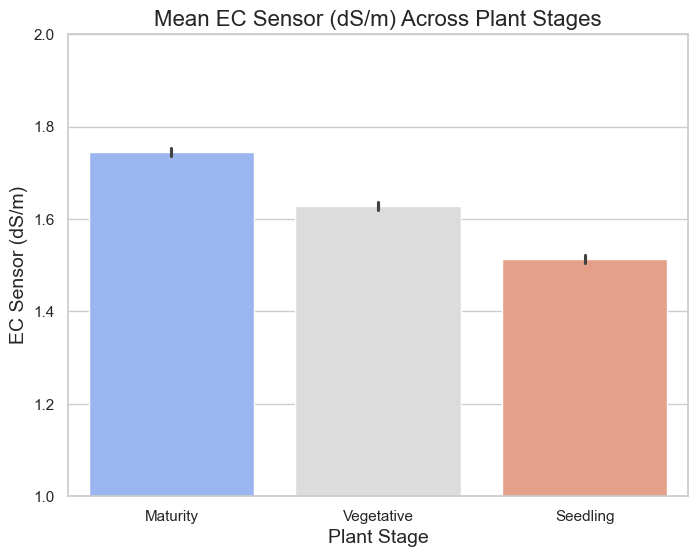

Summary statistics for EC Sensor (dS/m):
                   count      mean       std   min   25%   50%   75%  max
Plant Stage Name                                                         
Maturity          6372.0  1.745465  0.337989  0.57  1.54  1.75  1.96  2.7
Seedling          8093.0  1.513674  0.400367  0.56  1.22  1.51  1.80  2.7
Vegetative        7915.0  1.627942  0.388369  0.56  1.37  1.65  1.89  2.7


In [97]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(x='Plant Stage Name', y='EC Sensor (dS/m)', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)

plt.title('Mean EC Sensor (dS/m) Across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('EC Sensor (dS/m)', fontsize=14)

plt.ylim(1, 2)

plt.show()

summary_ec = df_cleaned.groupby('Plant Stage Name')['EC Sensor (dS/m)'].describe()
print("Summary statistics for EC Sensor (dS/m):")
print(summary_ec)

Based on my observation, electrical conductivity (EC) levels increase as plants progress through their growth stages, indicating higher nutrient uptake. Seedlings have the lowest average EC at 1.51 dS/m, with a median of 1.51 dS/m and a range from 0.56 to 2.7 dS/m, suggesting lower nutrient absorption at early stages. Vegetative plants show a moderate increase, averaging 1.63 dS/m, with a median of 1.65 dS/m, reflecting higher nutrient demand during structural growth. Mature plants exhibit the highest EC, averaging 1.75 dS/m and peaking at 2.7 dS/m, indicating a greater need for nutrients to sustain full development. This trend highlights how nutrient availability must be adjusted across plant stages for optimal growth.
***********************************************************************************************

***********************************************************************************************
6. Plant Stages and pH level 

The pH level is crucial for nutrient availability, as an optimal range ensures proper nutrient absorption. Boxplot reveals how pH levels vary across plant stages, showing differences in median values, spread, and outliers. This visualization helps identify whether pH remains stable or fluctuates as plants grow. By capturing the full range of pH values, the boxplot allows for a clear comparison between plant stages

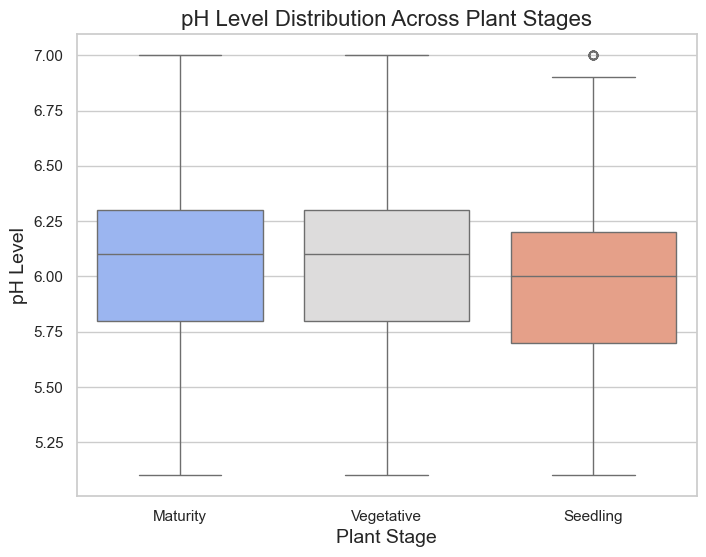

Summary statistics for pH Sensor:
                   count      mean       std  min  25%  50%  75%  max
Plant Stage Name                                                     
Maturity          6372.0  6.066290  0.377032  5.1  5.8  6.1  6.3  7.0
Seedling          8093.0  5.953627  0.352970  5.1  5.7  6.0  6.2  7.0
Vegetative        7915.0  6.061996  0.370188  5.1  5.8  6.1  6.3  7.0


In [98]:
plt.figure(figsize=(8, 6))

sns.boxplot(x='Plant Stage Name', y='pH Sensor', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)

plt.title('pH Level Distribution Across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('pH Level', fontsize=14)

plt.show()

summary_ph = df_cleaned.groupby('Plant Stage Name')['pH Sensor'].describe()
print("Summary statistics for pH Sensor:")
print(summary_ph)

Based on my observation, the summary statistics show that the pH levels across all three plant stages—Seedling, Vegetative, and Maturity—are quite similar. Seedlings have a mean pH of 5.95, Vegetative plants have a mean of 6.06, and Maturity plants have a mean of 6.07. The pH values range from 5.1 to 7.0 in all stages, with the interquartile range (25% to 75%) mostly between 5.7 to 6.3, showing only minor fluctuations. This consistency suggests that the plants are growing in a stable and optimal pH environment throughout their lifecycle, ensuring efficient nutrient uptake and supporting healthy growth at each stage.
******************************************************************************************

***********************************************************************************************
7. Plant Stages and System Location Code 

The system location code helps categorize different locations in the system, showing the distribution of plant stages across various locations. A heatmap is particularly useful here because it allows us to visually identify patterns and variations in the number of plants at each stage in different locations, with color intensity representing the count of plants. This makes it easy to spot areas with a higher concentration of certain plant stages, offering insights into plant distribution and management. The heatmap’s color gradients provide a clear visual representation of these patterns, making the data easier to interpret compared to raw data


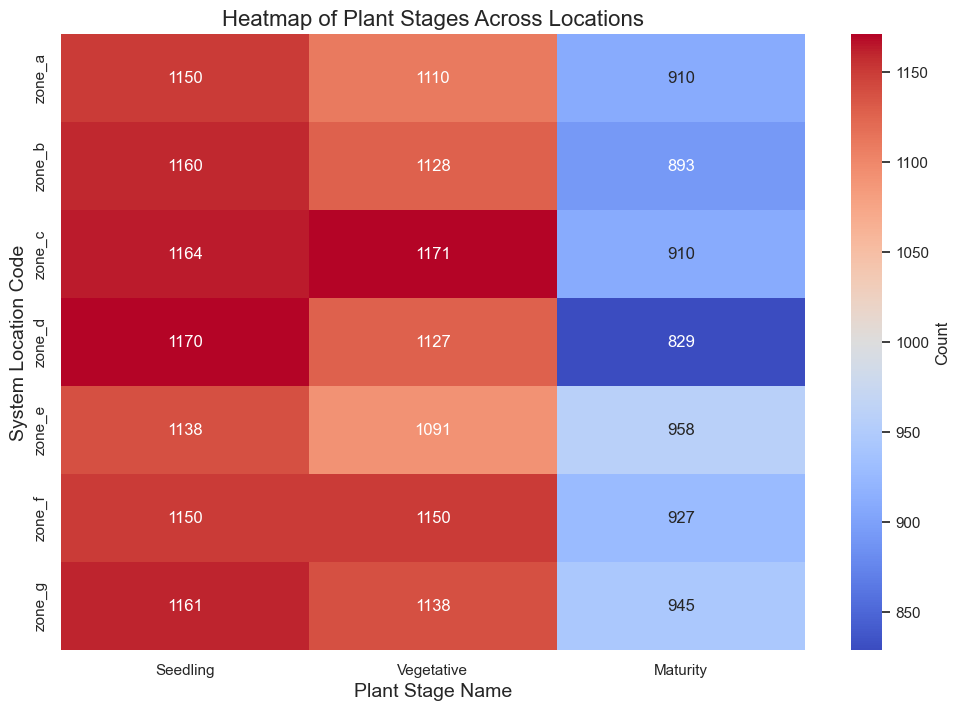

In [99]:
# Ensure Plant Stage Name is in the correct order
plant_stage_order = ['Seedling', 'Vegetative', 'Maturity']

# Create a pivot table
pivot_data = df_cleaned.pivot_table(index='System Location Code', 
                                    columns='Plant Stage Name', 
                                    aggfunc='size', 
                                    fill_value=0)

# Reorder columns if necessary
pivot_data = pivot_data[plant_stage_order]

plt.figure(figsize=(12, 8))

sns.heatmap(pivot_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Count'}, fmt='d')

plt.title('Heatmap of Plant Stages Across Locations', fontsize=16)
plt.xlabel('Plant Stage Name', fontsize=14)
plt.ylabel('System Location Code', fontsize=14)

plt.show()



However it is hard to compare all the different zones as they have different total amount of plant in each zone and therefore it would be better if we calculated the percentages of each plant stage in the different zones provide a clearer picture of how the plant stages are distributed across different locations. 


I then switched to a barplot as bar plot is  better than a heatmap in this case, heatmap is more useful for showing raw counts or density of occurrences, but here I am focusing on the percentage distribution of plant stages, which is more effectively communicated using bar heights, allowing me to easily direct compare how each stage contributes to the total percentage per location, giving a clearer view of the overall distribution

Summary Statistics for Plant Stages Across Locations:
   System Location Code Plant Stage Name  Count  Percentage
0                zone_a         Maturity    910   28.706625
1                zone_a         Seedling   1150   36.277603
2                zone_a       Vegetative   1110   35.015773
3                zone_b         Maturity    893   28.072933
4                zone_b         Seedling   1160   36.466520
5                zone_b       Vegetative   1128   35.460547
6                zone_c         Maturity    910   28.043143
7                zone_c         Seedling   1164   35.870570
8                zone_c       Vegetative   1171   36.086287
9                zone_d         Maturity    829   26.519514
10               zone_d         Seedling   1170   37.428023
11               zone_d       Vegetative   1127   36.052463
12               zone_e         Maturity    958   30.059617
13               zone_e         Seedling   1138   35.707562
14               zone_e       Vegetative   109

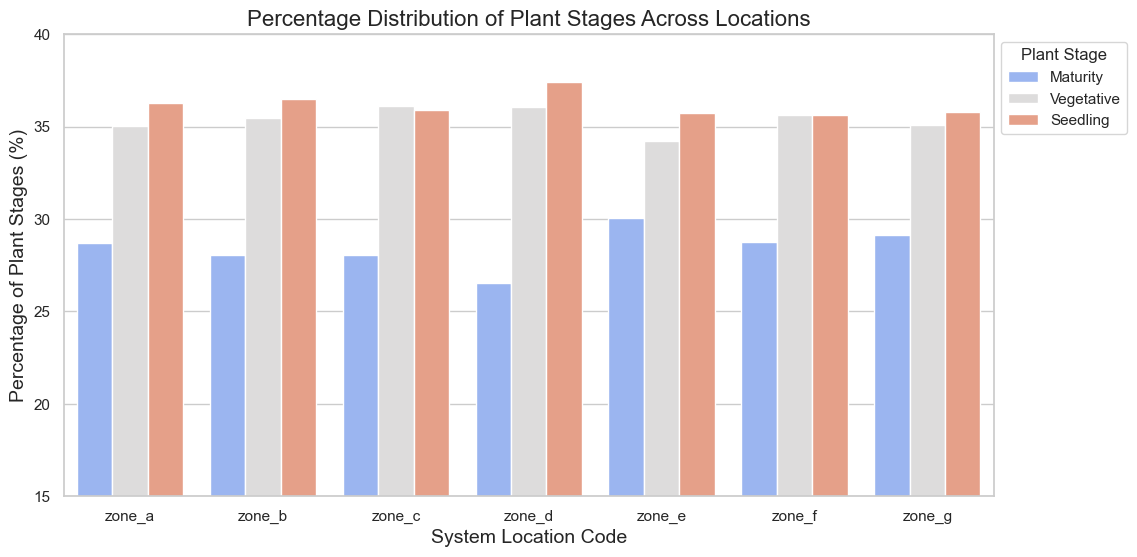

In [100]:
plant_stage_counts = df_cleaned.groupby(['System Location Code', 'Plant Stage Name']).size().reset_index(name='Count')
total_counts_per_location = plant_stage_counts.groupby('System Location Code')['Count'].transform('sum')
plant_stage_counts['Percentage'] = (plant_stage_counts['Count'] / total_counts_per_location) * 100

summary_stats = plant_stage_counts.groupby(['System Location Code', 'Plant Stage Name']).agg(
    Count=('Count', 'sum'),
    Percentage=('Percentage', 'mean')
).reset_index()

print("Summary Statistics for Plant Stages Across Locations:")
print(summary_stats)

plant_stage_order = ['Maturity', 'Vegetative', 'Seedling']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='System Location Code', y='Percentage', hue='Plant Stage Name', data=plant_stage_counts, palette='coolwarm', hue_order=plant_stage_order)

plt.title('Percentage Distribution of Plant Stages Across Locations', fontsize=16)
plt.xlabel('System Location Code', fontsize=14)
plt.ylabel('Percentage of Plant Stages (%)', fontsize=14)
plt.ylim(15, 40)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Plant Stage', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


Baed on my observation, Zone d is the best for seedlings, with the highest percentage of 37.43% of plants in the seedling stage. For the vegetative stage, Zonec is the most suitable, with 36.09% of plants in this phase but is very similar to Zone d too. Lastly for Zone e supports the highest percentage of mature plants, with 30.05 % in the maturity stage. In conclusion we can see that for early to mid stages, Zone d is the best but when it comes to maturity Zone e is the best.

***********************************************************************************************

***********************************************************************************************
8. Plant Stages and Plant Type

Plant types can influence plant stages by affecting the growth rate and development at different stages, with certain plant types requiring more or less time in each stage due to their specific growth needs. A barplot is used here to display the distribution of plant types across plant stages, as it provides a clear visual representation of how different plant types are distributed in each growth stage. The barplot allows for easy comparison between plant types and stages, which makes it a good choice for illustrating correlations and differences between the two variables.

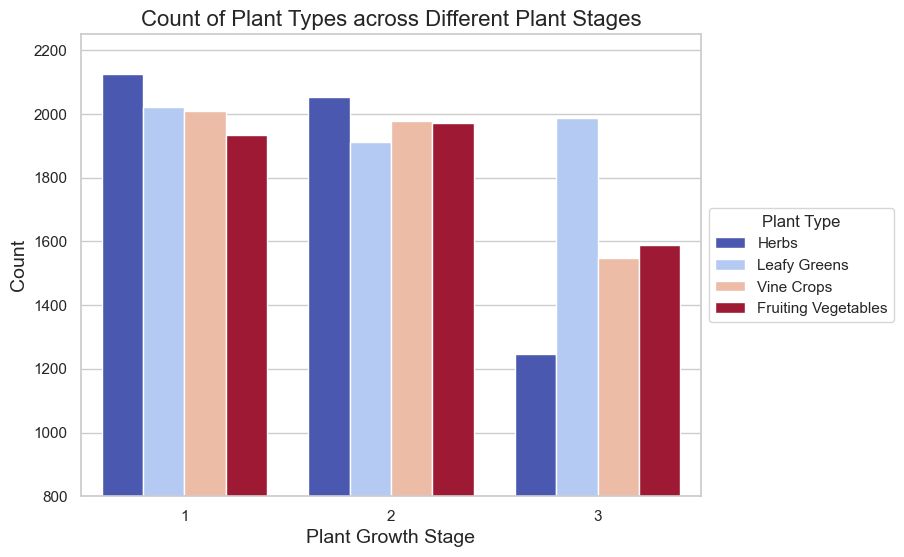

Summary Statistics for Count of Plant Types across Plant Stages:
Plant Type      1     2     3     4
Plant Stage                        
1            2125  2023  2010  1935
2            2054  1911  1977  1973
3            1247  1988  1547  1590


In [101]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Plant Stage', hue='Plant Type', data=df_cleaned, palette='coolwarm')

plt.title('Count of Plant Types across Different Plant Stages', fontsize=16)
plt.xlabel('Plant Growth Stage', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.ylim(800, 2250)

handles, labels = ax.get_legend_handles_labels()

plant_type_mapping = {
    1: 'Herbs',
    2: 'Leafy Greens',
    3: 'Vine Crops',
    4: 'Fruiting Vegetables'
}

new_labels = [plant_type_mapping[int(label)] for label in labels]
ax.legend(handles, new_labels, title='Plant Type', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

summary_stats = df_cleaned.groupby(['Plant Stage', 'Plant Type']).size().reset_index(name='Count')
summary_stats = summary_stats.pivot_table(index='Plant Stage', columns='Plant Type', values='Count', aggfunc='sum', fill_value=0)

print("Summary Statistics for Count of Plant Types across Plant Stages:")
print(summary_stats)

Based on my observation, Herbs have the highest counts in the Seedling and Vegetative stages but show a sharp decline in the Maturity stage (1247), indicating they mature quickly compared to other plant types. Leafy Greens have steady counts across all stages, with 2054 in Seedling and 1911 in Vegetative, suggesting they undergo a more gradual growth cycle. Vine Crops show a slight decline in the Maturity stage (1547), indicating a balance in growth stages. Fruiting Vegetables show consistent growth across stages, with 1935 in Seedling and 1590 in Maturity, implying they thrive in the early stages but experience a slight drop as they mature.

***********************************************************************************************

***********************************************************************************************
9. Plant Stages and Previous Cycle Plant Type:

"Previous Cycle Plant Type" can affect plant growth because the previous plant grown in the same location may impact soil health and nutrient availability which in turn can influence the growth of the current crop. A count plot is used here to visually display the distribution and frequency of plant stages across different previous cycle plant types, allowing for an easy comparison. Specifically, a count plot is ideal because it shows categorical data counts, making it perfect for understanding how the plant stages vary with the previous plant type.

Summary Statistics for Previous Cycle Plant Type and Plant Stage:
   Previous Cycle Plant Type Name Plant Stage Name  Count
0             Fruiting vegetables         Maturity   1593
1             Fruiting vegetables         Seedling   2032
2             Fruiting vegetables       Vegetative   2027
3                           Herbs         Maturity   1523
4                           Herbs         Seedling   2031
5                           Herbs       Vegetative   1957
6                    Leafy greens         Maturity   1611
7                    Leafy greens         Seedling   2063
8                    Leafy greens       Vegetative   1997
9                      Vine crops         Maturity   1645
10                     Vine crops         Seedling   1967
11                     Vine crops       Vegetative   1934


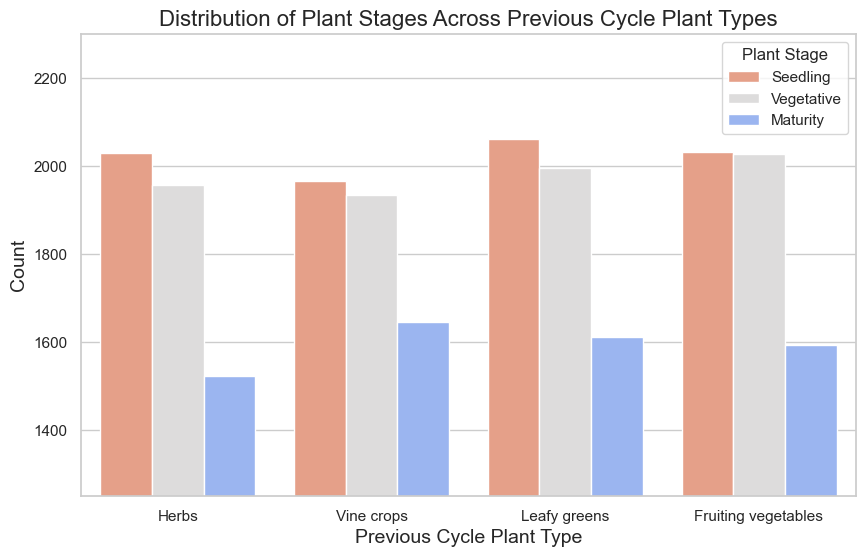

In [102]:
plant_type_mapping = {1: 'Herbs', 2: 'Leafy greens', 3: 'Vine crops', 4: 'Fruiting vegetables'}
df_cleaned['Previous Cycle Plant Type Name'] = df_cleaned['Previous Cycle Plant Type'].map(plant_type_mapping)

summary_stats = df_cleaned.groupby(['Previous Cycle Plant Type Name', 'Plant Stage Name']).size().reset_index(name='Count')
print("Summary Statistics for Previous Cycle Plant Type and Plant Stage:")
print(summary_stats)

# Get colors from the coolwarm palette and swap Seedling and Maturity
palette_colors = sns.color_palette("coolwarm", 3)
swapped_palette = {'Seedling': palette_colors[2], 'Vegetative': palette_colors[1], 'Maturity': palette_colors[0]} 

plt.figure(figsize=(10, 6))
sns.countplot(x='Previous Cycle Plant Type Name', hue='Plant Stage Name', data=df_cleaned, palette=swapped_palette, hue_order=['Seedling', 'Vegetative', 'Maturity'])

plt.title('Distribution of Plant Stages Across Previous Cycle Plant Types', fontsize=16)
plt.xlabel('Previous Cycle Plant Type', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.ylim(1250, 2300)

plt.legend(title='Plant Stage', loc='upper right')

plt.show()


Based on my observation, leafy greens have the highest number of seedlings (2063), followed closely by fruits vegetables (2032) and herbs (2031). However, herbs have the lowest number of mature plants (1523), indicating a lower maturation rate compared to other plant types. Fruiting vegetables have a fairly balanced distribution between seedlings (2032), vegetative (2027), and mature plants (1593), though their mature plant count is slightly lower. Vine crops, while having fewer seedlings (1967), exhibit a higher maturity count (1645) than the other plant types except leafy greens. 

***********************************************************************************************

***********************************************************************************************
10. Plant Stages and O2 Sensors (ppm)

Oxygen (O2) sensor values can affect plant growth because oxygen is essential for root respiration and energy production, which are crucial for healthy development, particularly during different plant stages. A barplot is used here to visually compare the average O2 sensor values across different plant stages, providing an easy-to-understand representation of the data. Specifically, a barplot is chosen because it effectively shows the differences in average O2 levels between the plant stages, helping to identify trends and patterns clearly.

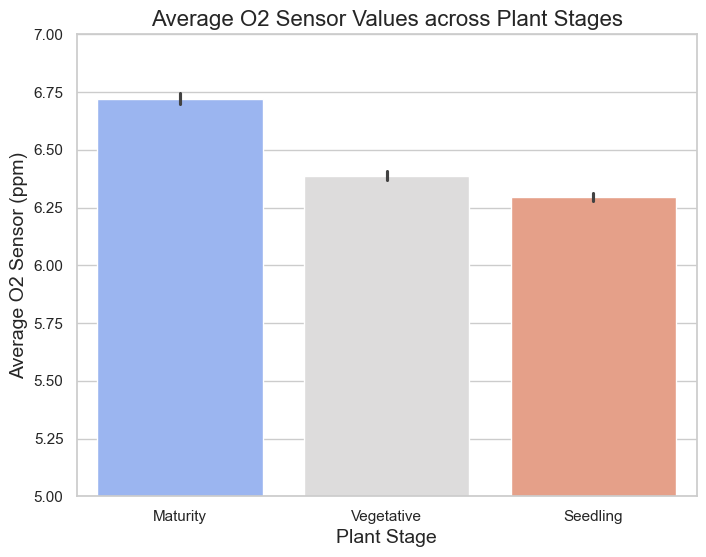

                   count      mean       std  min  25%  50%  75%  max
Plant Stage Name                                                     
Maturity          6372.0  6.721124  1.013133  5.0  6.0  7.0  8.0  8.0
Seedling          8093.0  6.294699  0.818120  5.0  6.0  6.0  7.0  8.0
Vegetative        7915.0  6.388377  0.905863  5.0  6.0  6.0  7.0  8.0


In [103]:
plant_stage_mapping = {1: 'Seedling', 2: 'Vegetative', 3: 'Maturity'}
df_cleaned['Plant Stage Name'] = df_cleaned['Plant Stage'].map(plant_stage_mapping)

plt.figure(figsize=(8, 6))
sns.barplot(x='Plant Stage Name', y='O2 Sensor (ppm)', data=df_cleaned, hue='Plant Stage Name', palette='coolwarm', legend=False)

plt.title('Average O2 Sensor Values across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('Average O2 Sensor (ppm)', fontsize=14)

plt.ylim(5, 7)

plt.show()

summary_o2 = df_cleaned.groupby('Plant Stage Name')['O2 Sensor (ppm)'].describe()
print(summary_o2)



Based on my observation, oxygen (O2) levels are highest in the Maturity stage (6.72 ppm), followed by Vegetative (6.39 ppm) and Seedling (6.29 ppm), suggesting that mature plants may require more oxygen due to their larger size and increased metabolic activity. Despite this, oxygen levels remain relatively stable across the stages, with values consistently ranging from 5 ppm to 8 ppm. The standard deviation is highest in the Maturity stage (1.01), indicating more variability in O2 levels among mature plants, while seedlings and vegetative plants show lower variation. This suggests that as plants mature, their oxygen needs may increase, but the overall range of O2 values remains constant across all stages.

***********************************************************************************************

***********************************************************************************************
11. Plant Stages and Water Level Sensor (mm)

A boxplot is ideal for visualizing water levels across plant stages because it clearly displays the distribution of data, including the median, quartiles, and potential outliers. This is important for understanding the spread and central tendency of water levels, as well as identifying any unusual variations or extremes in the data. Other plots, like bar or line plots, might not show the spread and distribution as effectively, especially when dealing with variations across different plant stages.

Statistical Summary of Water Level Across Plant Stages:

                   count       mean       std        min   25%   50%   75%  \
Plant Stage Name                                                             
Maturity          6372.0  26.299123  7.135923  10.004947  21.0  27.0  32.0   
Seedling          8093.0  24.462251  3.200225  18.000000  22.0  24.0  27.0   
Vegetative        7915.0  26.462500  6.072834  10.019150  22.0  27.0  31.0   

                        max  
Plant Stage Name             
Maturity          39.990544  
Seedling          30.000000  
Vegetative        39.998098  


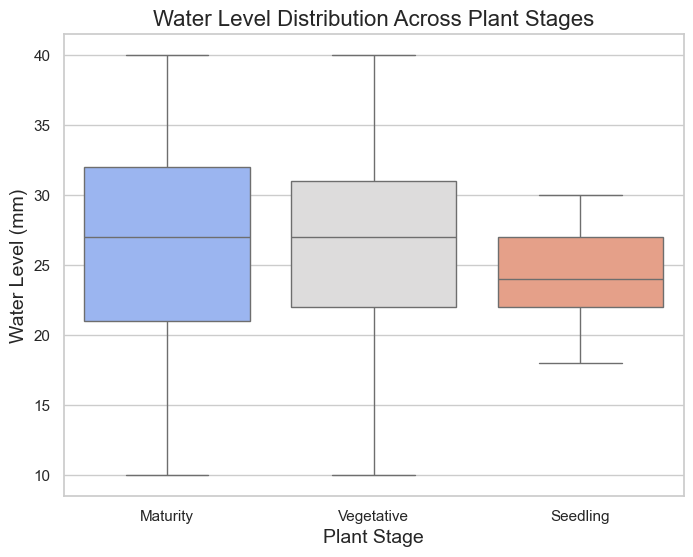

In [104]:
summary_water_level = df_cleaned.groupby('Plant Stage Name')['Water Level Sensor (mm)'].describe()
print("Statistical Summary of Water Level Across Plant Stages:\n")
print(summary_water_level)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Plant Stage Name', y='Water Level Sensor (mm)', 
            data=df_cleaned, palette='coolwarm', 
            hue='Plant Stage Name', legend=False)  
plt.title('Water Level Distribution Across Plant Stages', fontsize=16)
plt.xlabel('Plant Stage', fontsize=14)
plt.ylabel('Water Level (mm)', fontsize=14)

plt.show()

Based on my observation, the water levels required for plants increase with their growth stages, with the highest values observed in the maturity stage, which has a mean water level of 26.30 mm and a range from 10.00 mm to 39.99 mm. Seedlings, on the other hand, require lower and more consistent water levels, with a mean of 24.46 mm and a range from 18.00 mm to 30.00 mm. Vegetative plants need water levels similar to mature plants, with a mean of 26.46 mm and a range from 10.02 mm to 39.99 mm, but with slightly less variation (standard deviation of 6.07 mm compared to 7.14 mm for maturity).

These insights suggest that as plants mature, their water requirements become more variable and potentially higher, reflecting the increased size and complexity of the plant's growth needs.
***********************************************************************************************


********************************************************************
The EDA reveals distinct trends across plant stages, emphasizing stage-specific resource needs. Humidity data was not analyzed due to a large number of missing values. For other features, water and nutrient uptake increase as plants mature, with nitrogen and potassium peaking in the vegetative and maturity stages, while phosphorus is most critical in the vegetative phase. Oxygen and CO₂ levels rise with metabolic activity, though O₂ remains relatively stable across stages. pH remains consistent, ensuring efficient nutrient absorption. Light intensity increases with plant growth, while seedlings require more stable and slightly higher temperatures. Spatial analysis indicates that Zone D is most suitable for seedlings, Zone C supports vegetative growth, and Zone E is optimal for mature plants, suggesting that environmental conditions influence growth distribution. These findings highlight the importance of adjusting water, nutrients, and environmental conditions at different stages to optimize plant health, efficiency, and yield.
********************************************************************